In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV,cross_val_score,train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import tensorflow as tf
from tensorflow import python
from tensorflow import metrics

import warnings
warnings.filterwarnings('ignore')

# np.random.seed(1)
plt.style.use('ggplot')

In [2]:
df = pd.read_csv(r'./dataset/dataset_fix_clean.csv')

In [3]:
df.head()

,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,HealthImpactScore,HealthImpactClass
0,187.270059,295.853039,13.038560,6.639263,66.161150,54.624280,5.150335,84.424344,6.137755,97.244041,0.0
1,475.357153,246.254703,9.984497,16.318326,90.499523,169.621728,1.543378,46.851415,4.521422,100.000000,0.0
2,365.996971,84.443191,23.111340,96.317811,17.875850,9.006794,1.169483,17.806977,11.157384,100.000000,0.0
3,299.329242,21.020609,14.273403,81.234403,48.323616,93.161033,21.925276,99.473373,15.302500,100.000000,0.0
4,78.009320,16.987667,152.111623,121.235461,90.866167,241.795138,9.217517,24.906837,14.534733,95.182643,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5811 entries, 0 to 5810
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AQI                5811 non-null   float64
 1   PM10               5811 non-null   float64
 2   PM2_5              5811 non-null   float64
 3   NO2                5811 non-null   float64
 4   SO2                5811 non-null   float64
 5   O3                 5811 non-null   float64
 6   Temperature        5811 non-null   float64
 7   Humidity           5811 non-null   float64
 8   WindSpeed          5811 non-null   float64
 9   HealthImpactScore  5811 non-null   float64
 10  HealthImpactClass  5811 non-null   float64
dtypes: float64(11)
memory usage: 499.5 KB


In [5]:
df = df.drop(columns=['Temperature','Humidity','WindSpeed'], errors='ignore')
print(df.columns.tolist())

['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'HealthImpactScore', 'HealthImpactClass']


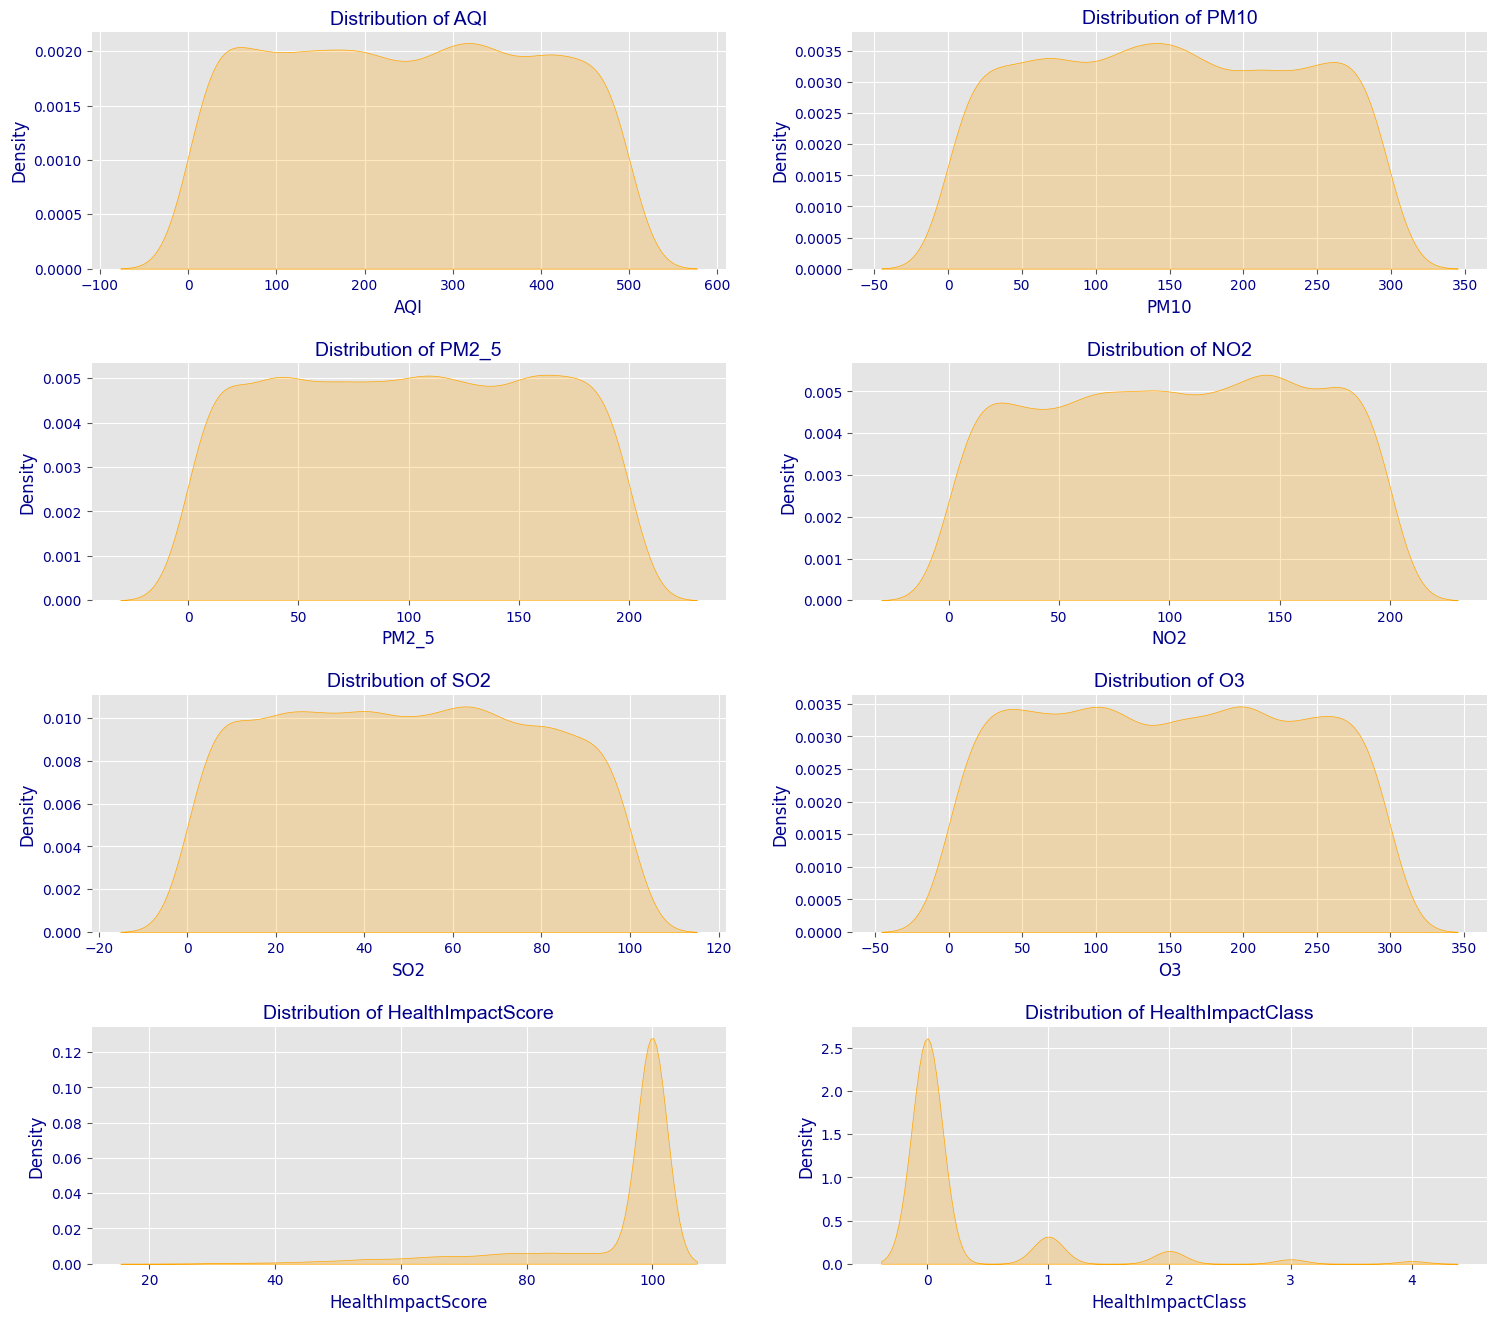

In [6]:
num_cols = len(df.columns)
columns = 2  # Number of columns for subplots
rows = -(-num_cols // columns)  # Calculate rows with ceiling division

fig, axes = plt.subplots(rows, columns, figsize=(18, rows * 4))  # Adjusted figure size
axes = axes.flatten()

for idx, feature in enumerate(df.columns):
    sns.kdeplot(data=df, x=feature, ax=axes[idx], fill=True, color='orange')  # Changed color to light blue

    axes[idx].set_title(
        f'Distribution of {feature}',
        fontdict={'family': 'Arial', 'color': 'darkblue', 'fontsize': 14, 'fontweight': 'medium'}
    )

    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].spines['left'].set_visible(False)
    axes[idx].spines['bottom'].set_visible(False)

    # Customize ticks and labels
    axes[idx].tick_params(axis='x', labelcolor='darkblue')
    axes[idx].tick_params(axis='y', labelcolor='darkblue')
    axes[idx].xaxis.label.set_color('darkblue')
    axes[idx].yaxis.label.set_color('darkblue')

# Hide any extra subplots not used
for extra_idx in range(len(df.columns), len(axes)):
    axes[extra_idx].set_visible(False)

plt.subplots_adjust(hspace=0.4)  # Adjust spacing between plots
plt.show()

In [7]:
df.describe()

,AQI,PM10,PM2_5,NO2,SO2,O3,HealthImpactScore,HealthImpactClass
count,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000
mean,248.438476,148.654997,100.223714,102.293445,49.456838,149.312431,93.785223,0.281191
std,144.777638,85.698500,58.096612,57.713175,28.530329,86.534240,13.318904,0.714075
min,0.005817,0.015848,0.031549,0.009625,0.011023,0.001661,22.448488,0.000000
25%,122.951293,75.374954,49.435171,53.538538,24.887264,73.999665,98.203057,0.000000
50%,249.127841,147.634997,100.506337,102.987736,49.530165,149.559871,100.000000,0.000000
75%,373.630668,222.436759,151.340260,151.658516,73.346617,223.380126,100.000000,0.000000
max,499.858837,299.901962,199.984965,199.980195,99.969561,299.936812,100.000000,4.000000


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

In [9]:
# Pisahkan fitur (X) dan target (y)
X = df[['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3']]
y = df['HealthImpactScore']

In [10]:
# Pastikan y diubah menjadi array numpy sebelum reshape
y = y.values.reshape(-1, 1)

# Normalisasi data menggunakan MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)


In [11]:
# 5. Mengubah data menjadi bentuk sekuensial untuk RNN/LSTM (samples, timesteps, features)
timesteps = 5  # Menggunakan 5 timestep sebelumnya untuk prediksi
X_seq, y_seq = [], []
for i in range(len(X) - timesteps):
    X_seq.append(X[i:i + timesteps])
    y_seq.append(y[i + timesteps])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [12]:
# 6. Membagi data menjadi train set dan test set
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


In [13]:
# 7. Membuat model RNN
rnn_model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(timesteps, X_seq.shape[2])),
    Dense(1, activation='linear')  # Output linear untuk regresi
])

In [14]:
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [15]:
# Menambahkan callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik yang dipantau
    patience=10,         # Jumlah epoch tanpa peningkatan sebelum berhenti
    restore_best_weights=True  # Mengembalikan bobot terbaik
)

In [16]:
# Melatih model RNN dengan EarlyStopping
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=50,  # Maksimal epoch
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Tambahkan EarlyStopping di sini
)

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0676 - mae: 0.1940 - val_loss: 0.0316 - val_mae: 0.1245
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0339 - mae: 0.1302 - val_loss: 0.0307 - val_mae: 0.1075
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0300 - mae: 0.1213 - val_loss: 0.0392 - val_mae: 0.1753
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0335 - mae: 0.1301 - val_loss: 0.0299 - val_mae: 0.1118
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0314 - mae: 0.1250 - val_loss: 0.0325 - val_mae: 0.1503
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0311 - mae: 0.1254 - val_loss: 0.0302 - val_mae: 0.1296
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0315 - mae: 0.1266 - val_loss: 0.0296 - val_mae: 0.1278
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0314 - mae: 0.1244 - val_loss: 0.0305 - val_mae: 0.0977
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

In [17]:
# 9. Membuat model LSTM
lstm_model = Sequential([
    LSTM(50, activation='tanh', input_shape=(timesteps, X_seq.shape[2])),
    Dense(1, activation='linear')  # Output linear untuk regresi
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [18]:
# Melatih model LSTM dengan EarlyStopping
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,  # Maksimal epoch
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Tambahkan EarlyStopping di sini
)

Epoch 1/50


146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1786 - mae: 0.3089 - val_loss: 0.0331 - val_mae: 0.1298
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0343 - mae: 0.1305 - val_loss: 0.0315 - val_mae: 0.1296
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0321 - mae: 0.1299 - val_loss: 0.0306 - val_mae: 0.1081
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 - mae: 0.1223 - val_loss: 0.0294 - val_mae: 0.1151
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301 - mae: 0.1196 - val_loss: 0.0290 - val_mae: 0.1201
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0274 - mae: 0.1157 - val_loss: 0.0296 - val_mae: 0.1340
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316 - mae: 0.1293 - val_loss: 0.0289 - val_mae: 0.1071
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 - mae: 0.1258 - val_loss: 0.0288 - val_mae: 0.1060
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 

In [19]:
# 11. Mengevaluasi model
rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test)
lstm_loss, lstm_mae = lstm_model.evaluate(X_test, y_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0271 - mae: 0.1149
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.0269 - mae: 0.1146


In [20]:
# 12. Menampilkan hasil evaluasi
results = {
    'RNN': {'Loss': rnn_loss, 'MAE': rnn_mae},
    'LSTM': {'Loss': lstm_loss, 'MAE': lstm_mae}
}

print("Hasil Evaluasi Model:")
print(results)

Hasil Evaluasi Model:
{'RNN': {'Loss': 0.028846649453043938, 'MAE': 0.11716005206108093}, 'LSTM': {'Loss': 0.028361300006508827, 'MAE': 0.11658729612827301}}


In [21]:
# Mengevaluasi model
rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test)
lstm_loss, lstm_mae = lstm_model.evaluate(X_test, y_test)
# Menampilkan akurasi
# Hitung akurasi sebagai 1 - Normalized MAE
y_test_inv = scaler_y.inverse_transform(y_test)  # Kembalikan skala asli untuk interpretasi
mae_rnn_scaled = scaler_y.inverse_transform([[rnn_mae]])[0][0]  # MAE RNN dalam skala asli
mae_lstm_scaled = scaler_y.inverse_transform([[lstm_mae]])[0][0]  # MAE LSTM dalam skala asli

accuracy_rnn = (1 - (mae_rnn_scaled / np.mean(y_test_inv))) * 100  # Akurasi RNN dalam persentase
accuracy_lstm = (1 - (mae_lstm_scaled / np.mean(y_test_inv))) * 100  # Akurasi LSTM dalam persentase

# Menampilkan hasil
print("Hasil Evaluasi Model:")
print(f"RNN - Loss (MSE): {rnn_loss:.4f}, MAE: {rnn_mae:.4f}, Akurasi: {accuracy_rnn:.2f}%")
print(f"LSTM - Loss (MSE): {lstm_loss:.4f}, MAE: {lstm_mae:.4f}, Akurasi: {accuracy_lstm:.2f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0271 - mae: 0.1149


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 0.0269 - mae: 0.1146
Hasil Evaluasi Model:
RNN - Loss (MSE): 0.0288, MAE: 0.1172, Akurasi: 66.51%
LSTM - Loss (MSE): 0.0284, MAE: 0.1166, Akurasi: 66.56%


In [23]:
# Mengevaluasi model
rnn_loss, rnn_mae = rnn_model.evaluate(X_test, y_test)
lstm_loss, lstm_mae = lstm_model.evaluate(X_test, y_test)

# Hitung akurasi dalam skala 0-1
# 1 - Normalized MAE
normalized_rnn_mae = rnn_mae / np.mean(y_test)  # Normalisasi MAE RNN
normalized_lstm_mae = lstm_mae / np.mean(y_test)  # Normalisasi MAE LSTM

accuracy_rnn = 1 - normalized_rnn_mae
accuracy_lstm = 1 - normalized_lstm_mae

# Menampilkan hasil
print("Hasil Evaluasi Model:")
print(f"RNN - Loss (MSE): {rnn_loss:.4f}, MAE: {rnn_mae:.4f}, Akurasi: {accuracy_rnn:.4f}")
print(f"LSTM - Loss (MSE): {lstm_loss:.4f}, MAE: {lstm_mae:.4f}, Akurasi: {accuracy_lstm:.4f}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 0.0271 - mae: 0.1149
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.0269 - mae: 0.1146
Hasil Evaluasi Model:
RNN - Loss (MSE): 0.0288, MAE: 0.1172, Akurasi: 0.8733
LSTM - Loss (MSE): 0.0284, MAE: 0.1166, Akurasi: 0.8739


In [27]:
# Pilih data terakhir dari data uji untuk memulai prediksi
last_input = X_test[-1]  # Data terakhir dalam bentuk (timesteps, features)

# Membuat tempat untuk menyimpan prediksi
predictions = []

# Iterasi untuk menghasilkan prediksi 3 hari ke depan
for _ in range(3):  # 3 hari ke depan
    # Prediksi berdasarkan input terakhir
    prediction = lstm_model.predict(last_input.reshape(1, last_input.shape[0], last_input.shape[1]))
    
    # Simpan hasil prediksi
    predictions.append(prediction[0, 0])
    
    # Perbarui input untuk prediksi berikutnya
    # Bentuk prediksi menjadi (1, features) agar sesuai dengan timestep
    prediction_reshaped = np.full((1, last_input.shape[1]), prediction[0, 0])  # Sesuaikan dimensi prediksi
    
    # Geser data input (buang timestep paling awal, tambahkan prediksi baru)
    next_input = np.vstack([last_input[1:], prediction_reshaped])  # Gabungkan dengan prediksi baru
    last_input = next_input

# Inverse transform hasil prediksi untuk kembali ke skala asli
predictions_scaled = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

# Output prediksi 3 hari ke depan
for i, pred in enumerate(predictions_scaled.flatten(), 1):
    print(f"Prediksi hari ke-{i}: {pred:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediksi hari ke-1: 94.5281
Prediksi hari ke-2: 92.7821
Prediksi hari ke-3: 93.6551


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluasi model pada data uji
y_pred_test = lstm_model.predict(X_test)

# Inverse transform hasil prediksi dan data aktual
y_pred_test_scaled = scaler_y.inverse_transform(y_pred_test)
y_test_scaled = scaler_y.inverse_transform(y_test)

# Hitung akurasi menggunakan metrik MAE dan MSE
mae = mean_absolute_error(y_test_scaled, y_pred_test_scaled)
mse = mean_squared_error(y_test_scaled, y_pred_test_scaled)
accuracy = 1 - (mae / np.mean(y_test_scaled))  # Akurasi dalam skala 0-1

# Tampilkan akurasi
print(f"Akurasi Model (skala 0-1): {accuracy:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Prediksi 3 hari ke depan
last_input = X_test[-1]
predictions = []

for _ in range(3):  # Prediksi 3 hari ke depan
    prediction = lstm_model.predict(last_input.reshape(1, last_input.shape[0], last_input.shape[1]))
    predictions.append(prediction[0, 0])
    prediction_reshaped = np.full((1, last_input.shape[1]), prediction[0, 0])
    next_input = np.vstack([last_input[1:], prediction_reshaped])
    last_input = next_input

# Inverse transform hasil prediksi untuk kembali ke skala asli
predictions_scaled = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

# Output prediksi 3 hari ke depan
print("\nPrediksi 3 Hari ke Depan:")
for i, pred in enumerate(predictions_scaled.flatten(), 1):
    print(f"Hari ke-{i}: {pred:.4f}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
Akurasi Model (skala 0-1): 0.9040
Mean Absolute Error (MAE): 9.0415
Mean Squared Error (MSE): 170.5716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Prediksi 3 Hari ke Depan:
Hari ke-1: 94.5281
Hari ke-2: 92.7821
Hari ke-3: 93.6551
